<a href="https://colab.research.google.com/github/joseortegalabra/MLBI/blob/master/NN_desde_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.losses import CategoricalCrossentropy   #con one hot encoding

In [0]:
#FUNCION SOFTMAX
from scipy.special import softmax   #funcion softmax   axis = 0 saco los valores por neuronas ubicadas en forma vertical, axis = 1 neuronas horizontales
def sooftmax(x):
  return softmax(x, axis = 0)

def d_softmax(z , y):   #recibe el z de forma horizontal, recibe Y de forma horizontal
  derivate = np.zeros((y.shape[0], y.shape[1], y.shape[1]))
  for i in range(y.shape[0]):  #recorrer datos
    for j in range(y.shape[1]):  #recorrer neronas de z
      for k in range(y.shape[1]): #recorrer neuronas de y
        if(j == k):
          derivate[i][j][k] =  y[i][j] * (1-y[j][k])
        else:
          derivate[i][j][k]  = - y[i][j] * y[j][k] 
  return derivate

In [0]:
#FUNCION SIGMOIDE
'''
def sigmoid(x):
    "Numerically stable sigmoid function."
    if x >= 0:
        z = exp(-x)
        return 1 / (1 + z)
    else:
        # if x is less than zero then z will be small, denom can't be
        # zero because it's 1+z.
        z = exp(x)
        return z / (1 + z)
'''
#funcion sigmoide
from scipy.special import expit

#funcion dervida sigmoide      derivada escalar simplemente evaluo en el Z
def d_sigmoid(z, y):
  derivate = np.zeros((z.shape[0], z.shape[1], z.shape[1]  ))
  for i in range(z.shape[0]): #recorro datos
    for j in range(z.shape[1]): #recorro neurona
      for k in range(z.shape[1]): 
        if(j == k):  #ESTOY EN LA DERIVADA QUE YO QQUIERO PORQUE ES JACOBIANO DE UNA FUNCION ESCALAR
          derivate[i][j][k] = expit(z[i][j]) * (1 - expit(z[i][j]))   
        else:
          derivate[i][j][k] = 0 #funcion de activacion escalar   
  print(derivate)
  return derivate

In [0]:
## LOSS MSE
def loss_mse(y_real, y_predicho):
  #paso un array 1xn de los valores reales y predichos
  #da mismos muy similares a  #from sklearn.metrics import mean_squared_error
  square = (y_real - y_predicho)**2
  return square.mean()

def derv_loss_mse(y_pred, y_real):    #funcion de la derivada de la loss elegida, en mi caso mse del profe predicho - real 
#CAMBIO EL ORDEN PARA QUE QUEDE EN MATRIZ(N°DATOS, N°NEURRONAS DE ULTIMA CAPA)
  return y_pred.T - y_real.T

In [0]:
### LOSS CROSS ENTROPY   label and probabilidades
def loss_cross_entropy(y_real, y_predicho):
  #funcion de loss FUNCIONA CON LOS VALORES EN DATA, OUTPUT y yo le paso los datos en OUTPUT, DATA
  #trasnformar
  loss = CategoricalCrossentropy()
  return loss(y_real.T, y_predicho.T).numpy()

def derv_loss_cross_entropy(y_pred, y_real):
  #target i / prediccion i
  y_pred = y_pred.T
  y_real = y_real.T
  return -y_real/y_pred

In [0]:
def calculate_grad_Z(grad_y, d_f_act, z, y):
  #para evaluar el jacobiano en cada punto de Z, z tiene que estar en el formato traspuesto ocupado en back (100X1) 100 datos x 1 neurona
  z = z.T
  y = y.T
  jacobian = d_f_act(z, y)  #jacobiano que obtengo es una matriz (data, (numero neuronas, numero neuronas))   #matriz de 3 dimensiones (datos, 3x3) softmax
  grad_Z = []
  for i in range(grad_y.shape[0]):
    grad_Z.append(grad_y[i] @ jacobian[i])   #me da 1x3
  grad_Z = np.array(grad_Z).reshape(grad_y.shape[0], grad_y.shape[1])
  print('GRADIENTE DE Z', grad_Z)
  return grad_Z

In [0]:
class model_nn():
  def __init__(self):
    #inicializar lista donde se guardaran los z, y, w, funciones de costos que utiliza el algoritmo para optimizar
    self.Z = [None]
    self.Y = [] #el y sub cero tiene un valor
    self.W = [] #dejo vacia la lista porque al crear los primeros W ahi voy a agregar el None en la primera capa
    self.b = []
    self.f_act = [None]
    self.d_f_act = [None]



    #donde guardar los valores obtenidos en cada paso de gradiente
    self.Z_hist = []
    self.Y_hist = []
    self.W_hist = []
    self.b_hist = []
  
  def reset_params(self): #reiniciar para hacer otra corrida de forward con valores W guardados y las funciones de activacion
    self.Z = [None]
    self.Y = [] 

  def add_layer(self,  n_neuron_actual, n_features = None, activation_function = None, derivate_act_function = None):
    if self.W:
      #no esta vacia la red neuronal
      self.W.append(np.random.normal(size = (n_neuron_actual, self.n_neuron_last_layer)))
      self.b.append(np.random.normal(size = (n_neuron_actual, 1)))   #llega a la cantidad actual de neuronas a partir de 1
      #AGREGAR FUNCION DE ACTIVACIÓN
      self.f_act.append(activation_function)
      self.d_f_act.append(derivate_act_function) 
      self.n_neuron_last_layer = n_neuron_actual
      

#cuando creo la nueva capa tengo que agregar el bias de la capa anterior 
    else:
      #esta vacia la red 
      self.W.append(None)
      self.b.append(None)
      self.W.append(np.random.normal(size = (n_neuron_actual, n_features)))
      self.b.append(np.random.normal(size = (n_neuron_actual, 1)))   #llega a la cantidad actual de neuronas a partir de 1
      #AGREGAR FUNCION DE ACTIVACIÓN
      self.f_act.append(activation_function) 
      self.d_f_act.append(derivate_act_function) 
      self.n_neuron_last_layer = n_neuron_actual

  def add_loss(self, loss_function, derivate_loss_function):
    self.loss = loss_function
    self.d_loss = derivate_loss_function

#podria crear solo la matriz de pesoss y las matrices Zk y Yk se crean solo cuando entreno para poder hacer variables la cantidad de datos de entrada
  
  #hacer el forward un forward pass inicial con todos los datos y las calibraciones inciiales para ver los valores en cada capa
  def forward_pass(self, data):
    self.Y.append(data)  #asigno y[k = 0] primera capa
    
    
    for k in range(1, len(self.W)):   
      #expandir dimensiones de y 
      Y_exp = np.vstack((np.ones(data.shape[1]), self.Y[k-1])) #en cada iteracion agrego el 1 
      W_exp = np.hstack(( self.b[k] , self.W[k] ))  #juntar weights y bias auxiliar para calculos
      
      self.Z.append(W_exp @ Y_exp)
      self.Y.append( self.f_act[k](self.Z[k]) )

  def backward_pass(self, y_real):
    self.N = len(self.Y) - 1  #cantidad de capas creadas (capa 0, capa 1, capa2, capa3)
    
    #crear gradientes en cada back y actualizarlos en la iteración
    self.grad_Y = [0 for i in range(len(self.Y))] #lista con 4 ubicaciones para hacer mis capas
    self.grad_Z = [0 for i in range(len(self.Y))] 
    self.grad_W = [0 for i in range(len(self.Y))] 
    self.grad_b = [0 for i in range(len(self.Y))] 

    while (self.N > 0):
      print('\n\n------CAPA ------', self.N)
      self.deltaW = [0 for i in range (len(self.Y))]   #crear el delta para actualizar NOSE SI ES NECESARIO
      self.deltab = [0 for i in range (len(self.Y))] 
 
      
      if (self.N  == len(self.Y) - 1):   #solo para la ultima capa
        self.grad_Y[self.N] =  model.d_loss(self.Y[self.N], y_real)   #derivada de la Loss
        #print('GRADIENTE DE Y', self.grad_Y[self.N] )

      else:  #caso contrario que no estoy en la ultima capa
      #LOS VALORES LOS AGREGO EN EL ORDEN INVERSO, TENGO QUE AGREGAR UNA ESPACIO NULO Y SUFFLE DE LO QUE OBTENGO, ahi queda ordenado de 0,1,2,3
        self.grad_Y[self.N] = self.grad_Z[self.N + 1] @ self.W[self.N + 1]


      #calcular gradiente de z necesito la derivada de la funcion de activacion evaluada en Z
      #en escalar solo necesito evaluar en z, en vectorial softmax necesito el valor de z ademas de valor de y
      #generalizo y paso el Z y el Y para usarlos en la funcion de calculo de gradiente (funcion de activacion de la capa n)segun corresponda 
      self.grad_Z[self.N] =  calculate_grad_Z(self.grad_Y[self.N], self.d_f_act[self.N],self.Z[self.N], self.Y[self.N])
      
      self.grad_W[self.N] = self.Y[self.N - 1] @ self.grad_Z[self.N]
      self.grad_b[self.N] = np.ones((1, self.Y[0].shape[1])) @ self.grad_Z[self.N] #ones de los datos self.Y[0].shape[1] cantidad de datos en todos los y son =
      self.N -=1

  def update_weights(self, lr):
    for k in range(1, len(self.W)):
      self.W[k] = self.W[k] - ( lr /  self.Y[0].shape[1] ) * self.grad_W[k].T
      self.b[k] = self.b[k] - ( lr /  self.Y[0].shape[1] ) * self.grad_b[k].T

# MODELO ENTRENAR

In [8]:
X = np.array([
              [25, 50, 1, 10],
              [25, 20, 0, 10],
              [20, 50, 1, 10 ],
              [10, 60, 0, 20 ],
              [10, 30, 0, 5 ],
              [10, 20, 1, 5 ]
])

y = np.array([[3], [2], [3], [3], [2], [1]])
#y = np.array([[0,0,1], [0,1,0], [0,0,1], [0,0,1], [0,1,0], [1,0,0]])

print('Data x', X)
print('Data y', y)

Data x [[25 50  1 10]
 [25 20  0 10]
 [20 50  1 10]
 [10 60  0 20]
 [10 30  0  5]
 [10 20  1  5]]
Data y [[3]
 [2]
 [3]
 [3]
 [2]
 [1]]


#### conjunto train y test

In [9]:
X_train = X
y_train = y
print(X_train) #datos ordenados de forma correcta en el eje y los valores de las features
print('y_train en horizontal los datos', y_train)

[[25 50  1 10]
 [25 20  0 10]
 [20 50  1 10]
 [10 60  0 20]
 [10 30  0  5]
 [10 20  1  5]]
y_train en horizontal los datos [[3]
 [2]
 [3]
 [3]
 [2]
 [1]]


In [0]:
def suffle_data(x, y):
  #x e y tiene que estar en formato de matrices (dato, feature), (dato, salida)
  #RETURN PARA RED NEURONAL (FEATURE, DATO)  ,  (SALIDA, DATO)
  data = np.hstack(( x, y ))
  data_index = np.hstack(( np.array(    [[i] for i in range(x.shape[0])]   ) , data ))

  np.random.shuffle(data_index)

  x_shuffle = data_index[:, 1: data_index.shape[1]-y.shape[1] ].T
  y_shuffle = data_index[:, 1+x.shape[1]:].T
  return x_shuffle, y_shuffle

In [0]:
def get_batch(x, y, size_batch, i):
  return x[: , i*size_batch : i*size_batch+size_batch ], y[: , i*size_batch : i*size_batch+size_batch ]

#### hacer red y entrenar

In [12]:
model = model_nn()
model.add_layer(5, 4, activation_function = expit, derivate_act_function = d_sigmoid) #4 features
model.add_layer(3, activation_function = expit, derivate_act_function = d_sigmoid)
model.add_layer(1, activation_function = expit, derivate_act_function = d_sigmoid)
model.add_loss(loss_mse, derv_loss_mse)

#model.add_layer(3, activation_function= sooftmax,   derivate_act_function= d_softmax)
#model.add_loss(loss_cross_entropy, derv_loss_cross_entropy)


print('tamaño neuronas')
print(model.W[0])
print(model.W[1].shape)
print(model.W[2].shape)
print(model.W[3].shape)

print('\n Activation function', model.f_act)
print('Derivate activation function', model.d_f_act)
print('Loss:', model.loss, 'Derivate_loss:', model.d_loss)

tamaño neuronas
None
(5, 4)
(3, 5)
(1, 3)

 Activation function [None, <ufunc 'expit'>, <ufunc 'expit'>, <ufunc 'expit'>]
Derivate activation function [None, <function d_sigmoid at 0x7f8cc9cb8f28>, <function d_sigmoid at 0x7f8cc9cb8f28>, <function d_sigmoid at 0x7f8cc9cb8f28>]
Loss: <function loss_mse at 0x7f8cc9cc3730> Derivate_loss: <function derv_loss_mse at 0x7f8cc9cc37b8>


In [0]:
#epoch = 10
epoch = 10
lr = 0.001
size_batch = 3  #3 DATOS EN CADA BATCH
num_batches = int(X_train.shape[1] / size_batch) + 1      #le sumo uno para hacer bien el for que recorre los batches

In [35]:
loss = []

for i in range(epoch):
  #shuffle de todo el train set
  loss_batch = 0
  X_shuffled, y_shuffled = suffle_data(X_train, y_train)
  #print('DataX shuffled [features, data]\n',X_shuffled)
  #print('Datay shuffled [salida, data]',y_shuffled)
  for j in range(num_batches):
    print('epoch:', i, 'batch:', j)
    #obtener batch
    X_train_batch, y_train_batch = get_batch(X_shuffled, y_shuffled, size_batch , j)
    #print(X_train_batch)
    #print(y_train_batch.shape)
    
    ###FORWARD PASS
    model.forward_pass(X_train_batch)  

    print(model.Z[-1])
    print(model.Y[-1])
    
    #CALCULAR LA LOSS DE LA REGRESION EN ESE FORWARD  (y_true, y_predicho)
    #TENGO QUE SACAR EL PROMEDIO DE LA LOSS PARA PODER GRAFICAR LA LOSS DE LA EPOCA
    #loss_batch += loss_mse(y_train_batch ,model.Y[-1])
    loss_batch += model.loss(y_train_batch, model.Y[-1])  
    print('LOSS BATCH', loss_batch)

    ###BACK PASS
    model.backward_pass(y_train_batch)
    model.update_weights(lr)   #actualizo los pesos

    #TERMINO UN PASO DE GRADIENTE
    model.reset_params()      #reinicio los y, z para calcular los nuevos y, z en el siguiente paso de gradiente

  #promedio de la loss
  loss.append(  loss_batch/num_batches )




epoch: 0 batch: 0
[[4.01258981 4.01253154 4.01258978]]
[[0.98223482 0.9822338  0.98223482]]
LOSS BATCH 2.7143561052525116


------CAPA ------ 3
[[[0.01744958]]

 [[0.01745056]]

 [[0.01744958]]]
GRADIENTE DE Z [[-0.03520916]
 [-0.00031003]
 [-0.03520916]]


------CAPA ------ 2
[[[0.24358476 0.         0.        ]
  [0.         0.24418474 0.        ]
  [0.         0.         0.22488374]]

 [[0.2435724  0.         0.        ]
  [0.         0.24418258 0.        ]
  [0.         0.         0.22490484]]

 [[0.24358476 0.         0.        ]
  [0.         0.24418474 0.        ]
  [0.         0.         0.22488375]]]
GRADIENTE DE Z [[-2.76270686e-03 -9.71598045e-03 -5.87801351e-03]
 [-2.43254630e-05 -8.55521923e-05 -5.17630293e-05]
 [-2.76270687e-03 -9.71598068e-03 -5.87801395e-03]]


------CAPA ------ 1
[[[3.47686253e-22 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 7.17081685e-37 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000

In [36]:
len(loss)

10

In [37]:
loss[-1]

2.3809789668171915

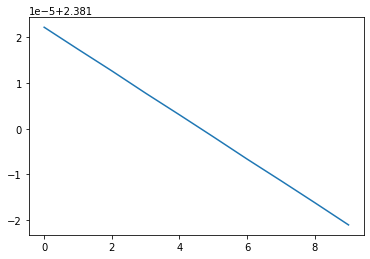

In [38]:
plt.plot(loss)

In [39]:
loss[0]

2.3810221981147968